In [1]:
# all tensorflow api is accessible through this
# webhdfs http://10.0.104.163:50070
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt 

In [2]:
# tf.set_random_seed(0)                                           
from os import listdir
from os.path import isfile, join
from scipy import misc
import numpy as np

basePath = "spacenet-dataset/AOI_1_Rio/processedData/3band/"
basePathLabel = "spacenet-dataset/AOI_1_Rio/processedData/labels_3band/"
dataset = dict({"data": np.empty(shape=(0,406,439,3)), "labels": np.empty(shape=(0,406,439,1))})
for f in listdir(basePathLabel):
    fileAux = f.split('.')[0] + ".tif"
    pathImage = join(basePath, fileAux)
    pathLabel = join(basePathLabel, f)
    imageLabel = misc.imread(pathLabel)
    imageLabel.resize((1, 406,439,1))
    image = misc.imread(pathImage)
    image.resize((1, 406,439,3))
    dataset["data"] = np.concatenate((dataset["data"],image), axis=0)
    dataset["labels"] = np.concatenate((dataset["labels"],imageLabel), axis=0)

In [4]:
# 1. Define Variables and Placeholders
#the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 406, 439, 3])
Y_ = tf.placeholder(tf.float32, [None, 406, 439, 1]) # correct answers(labels)

# placeholder for probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
pkeep = tf.placeholder(tf.float32)

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.004
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 500, 0.93)

#define weights and bias for convolutional layers
W1 = tf.Variable(tf.truncated_normal([5, 5, 3, 13], stddev=0.1))
B1 = tf.Variable(tf.zeros([13])) #Bias

W2 = tf.Variable(tf.truncated_normal([5, 5, 13, 24], stddev=0.1))
B2 = tf.Variable(tf.zeros([24])) #Bias

W3 = tf.Variable(tf.truncated_normal([5, 5, 24, 36], stddev=0.1))
B3 = tf.Variable(tf.zeros([36])) #Bias

W4 = tf.Variable(tf.truncated_normal([5, 5, 24, 36], stddev=0.1))
B4 = tf.Variable(tf.zeros([24])) #Bias

W5 = tf.Variable(tf.truncated_normal([5, 5, 13, 24], stddev=0.1))
B5 = tf.Variable(tf.zeros([13])) #Bias

W6 = tf.Variable(tf.truncated_normal([5, 5, 1, 13], stddev=0.1))
B6 = tf.Variable(tf.zeros([1])) #Bias



#W_fc1 = tf.Variable(tf.truncated_normal([8*8*36, 200], stddev=0.1))
#B_fc1 = tf.Variable(tf.zeros([200])) #Bias

#W_fc2 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
#B_fc2 = tf.Variable(tf.zeros([10])) #Bias


In [69]:
# 2. Define the model - compute predicitions
#Y_I = tf.nn.relu(tf.nn.conv2d(<input>, <weights>, strides=[<batch_step>, <height_step>, <width_step>, <channel_step>], padding=’SAME’) + <bias>)

# 3 convolutional layers
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1,2,2,1], padding='SAME') + B1)

Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1,2,2,1], padding='SAME') + B2)

Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1,2,2,1], padding='SAME') + B3)

Y4 = tf.nn.relu(tf.nn.conv2d_transpose(Y3, 
                            W4, 
                            tf.pack([tf.shape(Y3)[0], 102, 110, 24]),
                            strides=[1, 2, 2, 1], padding='SAME') + B4)

Y5 = tf.nn.relu(tf.nn.conv2d_transpose(Y4, 
                            W5, 
                            tf.pack([tf.shape(Y4)[0], 203, 220, 13]),
                            strides=[1, 2, 2, 1], padding='SAME') + B5)
Ylogits = tf.nn.conv2d_transpose(Y5, 
                            W6, 
                            tf.pack([tf.shape(Y5)[0], 406, 439, 1]),
                            strides=[1, 2, 2, 1], padding='SAME') + B6
Y = tf.nn.relu(Ylogits)

# Densely conected layer
#Y3_flat = tf.reshape(Y3, [-1, 8*8*36])
#Y_fc1 = tf.nn.relu(tf.matmul(Y3_flat, W_fc1) + B_fc1)
#Y_fc1d = tf.nn.dropout(Y_fc1, pkeep)

# Readout layer
#Y = tf.nn.softmax(tf.matmul(Y_fc1d, W_fc2) + B_fc2)


In [77]:
# Train & test data
from random import shuffle
size = dataset["labels"].shape[0]
x = [i for i in range(size)]
shuffle(x)
train_indices = x[:int(size*0.7)]
test_indices = x[int(size*0.7):]

def next_batch(_data, i, indices, batch_size):
   data_len = len(indices)
   _indices = map(lambda x: indices[x % data_len], range(batch_size*i, batch_size*(i+1)))
   return _data["data"][_indices], _data["labels"][_indices]

In [95]:
# 3. Define the loss function
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y_ * tf.log(Y), reduction_indices=[1]))

#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(Ylogits, Y_) # calculate cross-entropy with logits #softmax_cross_entropy_with_logits
#cross_entropy = tf.reduce_mean(cross_entropy)
#cross_entropy = tf.reduce_sum(tf.square(Y_ - Y))
cross_entropy = tf.reduce_mean(tf.square(Y_ - Y))

In [96]:
# 4. Define the accuracy
correct = tf.equal(Y_, Y)
#accuracy = tf.reduce_mean(tf.reduce_sum(tf.cast(correct, tf.float32))/(406*439))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [97]:
# 5. Train with an Optimizer

#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy) #Learning rate of 0.5
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy) #Learning rate of 0.5

In [154]:

def training_step(i, update_test_data, update_train_data):

    print "\rComplete: ", i, 
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = next_batch(dataset, i, train_indices, 10)
    
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, global_step: i, pkeep: 0.75})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    y = None
    batch_testX = None
    batch_testY = None
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y, global_step: i, pkeep: 1.0})
        train_a.append(a)
        train_c.append(c)
        

    if update_test_data:
        batch_testX, batch_testY = next_batch(dataset, i, test_indices, len(test_indices))
        a, c, y = sess.run([accuracy, cross_entropy, Y], feed_dict={X: batch_testX, Y_: batch_testY, global_step: i, pkeep: 1.0})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c, batch_testX, y, batch_testY)

Complete:  0 (406, 439, 3)


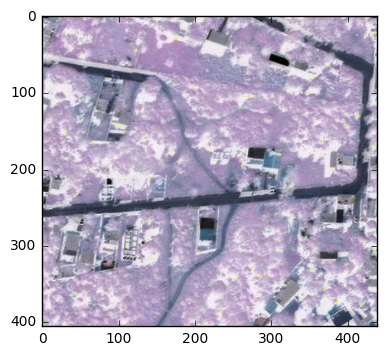

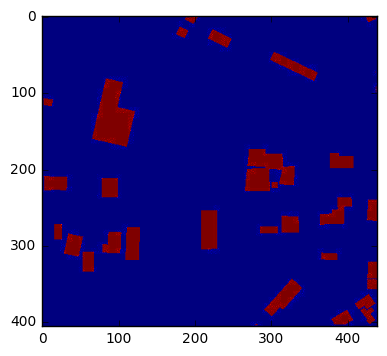

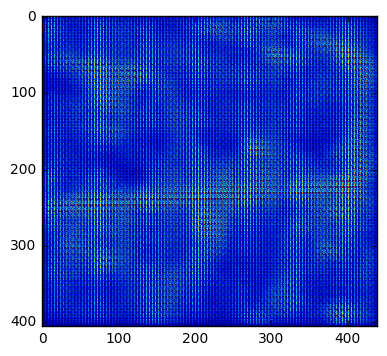

Complete:  5 (406, 439, 3)


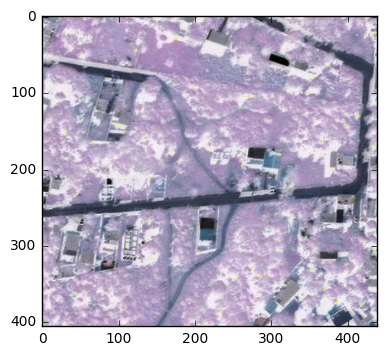

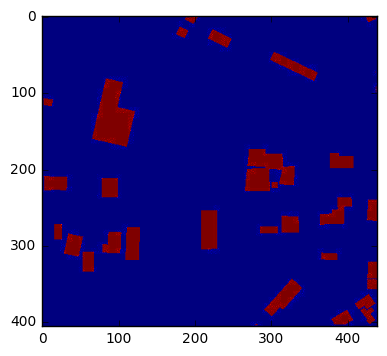

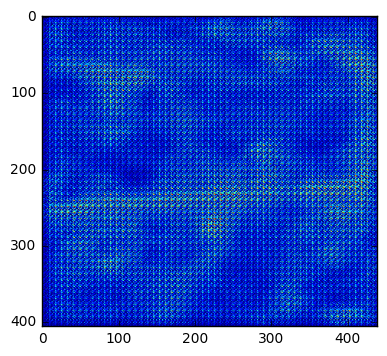

Complete:  10 (406, 439, 3)


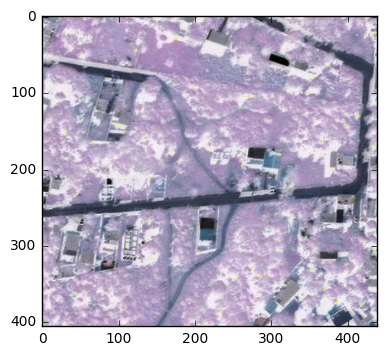

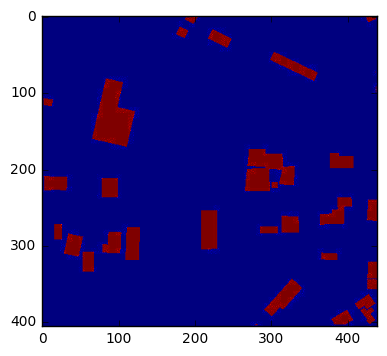

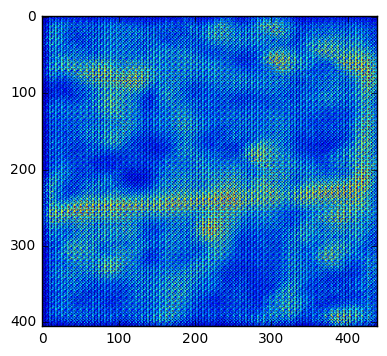

Complete:  15 (406, 439, 3)


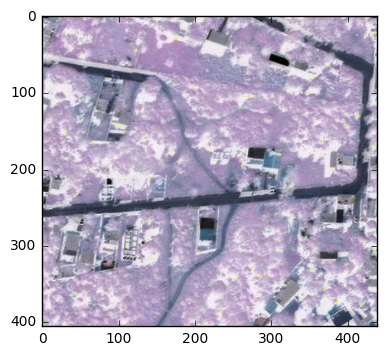

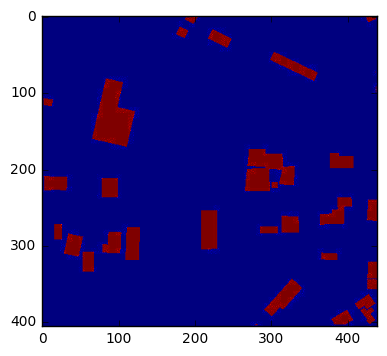

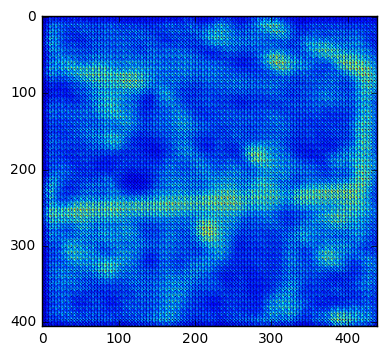

Complete:  20 (406, 439, 3)


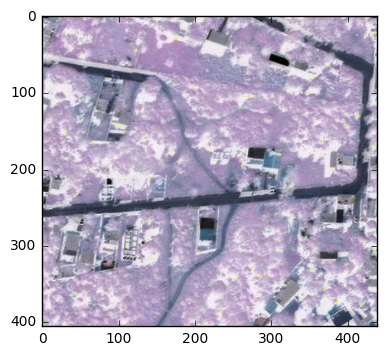

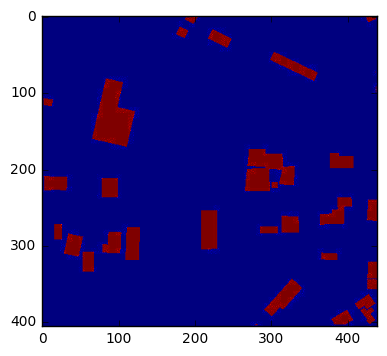

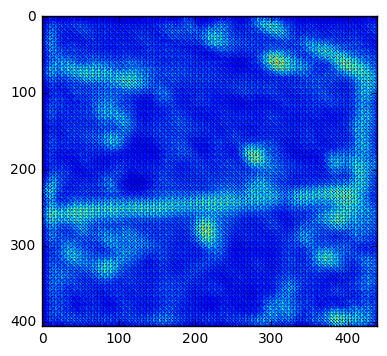

Complete:  25 (406, 439, 3)


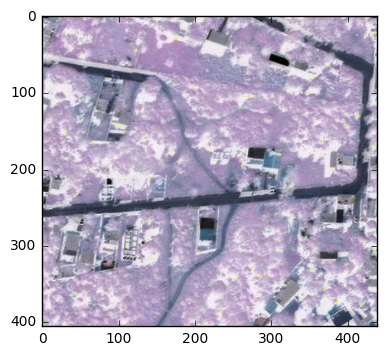

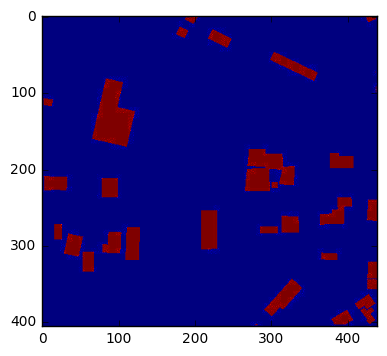

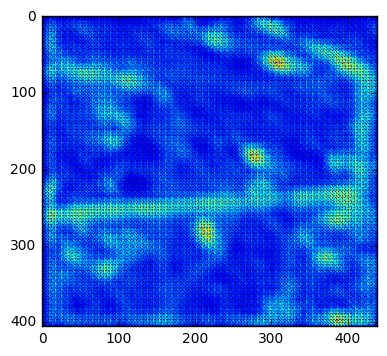

Complete:  30 (406, 439, 3)


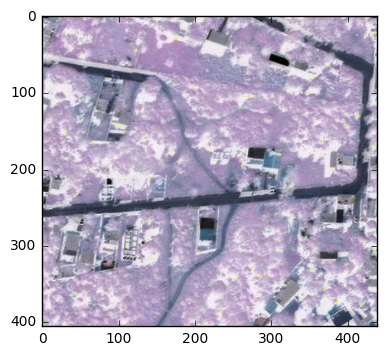

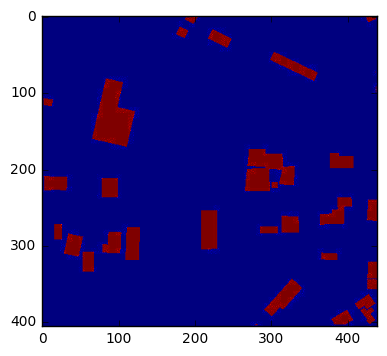

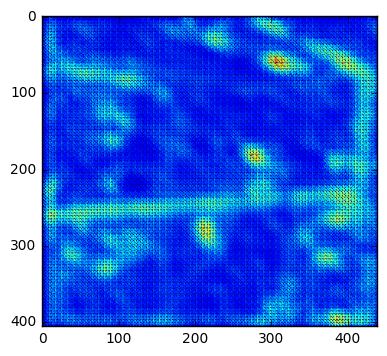

Complete:  35 (406, 439, 3)


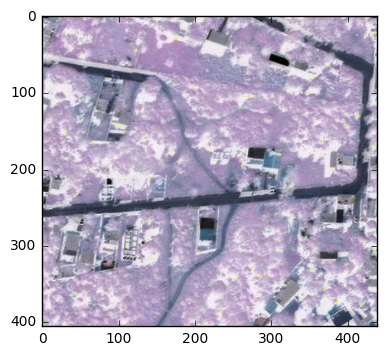

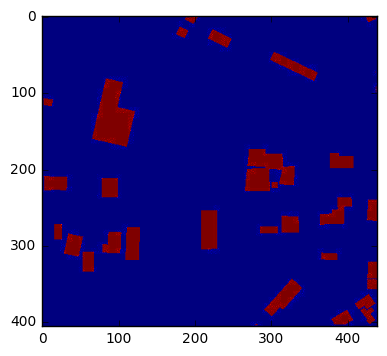

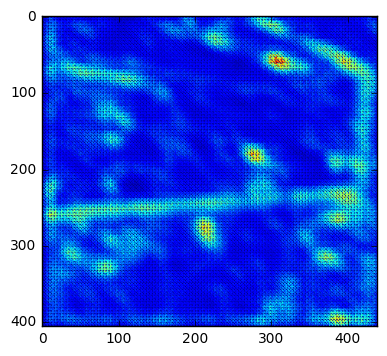

Complete:  40 (406, 439, 3)


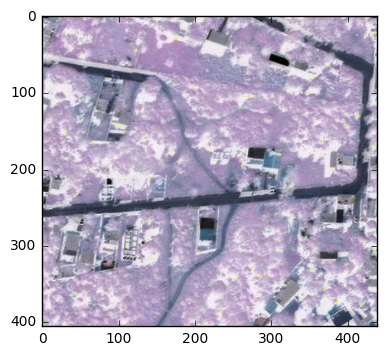

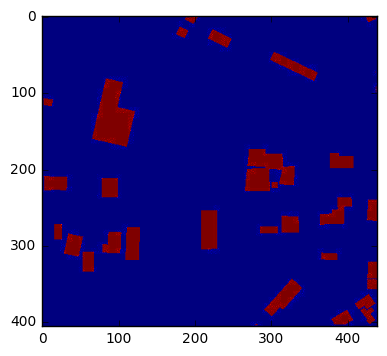

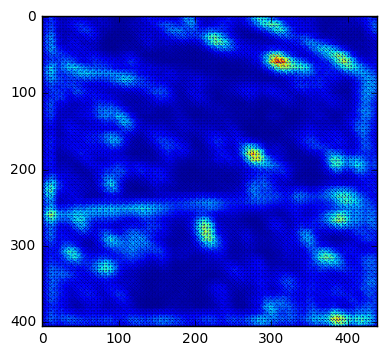

Complete:  44

KeyboardInterrupt: 

In [155]:
# 6. Train and test the model, store the accuracy and loss per iteration
# initialize
tf.set_random_seed(0)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 500
epoch_size = 5

for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc, original, image, image_real = training_step(i, test, test)
    if image is not None:
        ind = 5
        print(original[ind].shape)
        plt.imshow(original[ind])
        plt.show()
        plt.imshow(np.resize(image_real[ind], (image_real[ind].shape[0], image_real[ind].shape[1])))
        plt.show()
        plt.imshow(np.resize(image[ind], (image[ind].shape[0], image[ind].shape[1])))
        plt.show()
        
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc

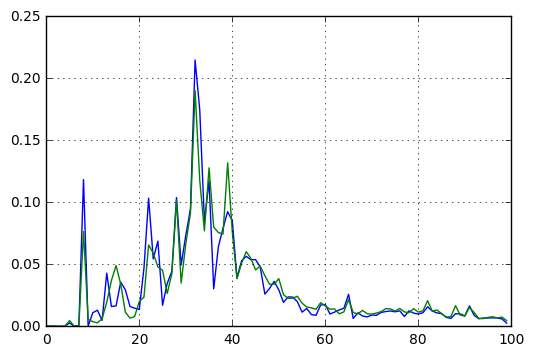

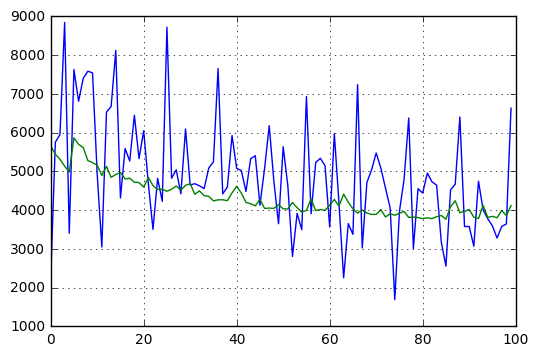

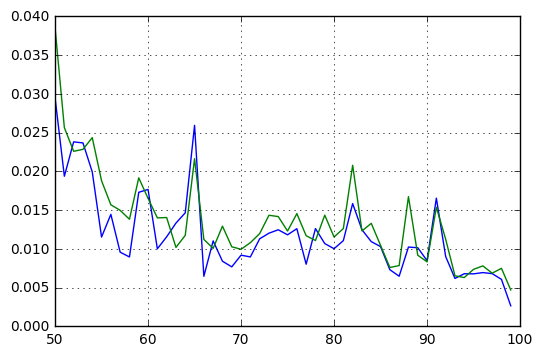

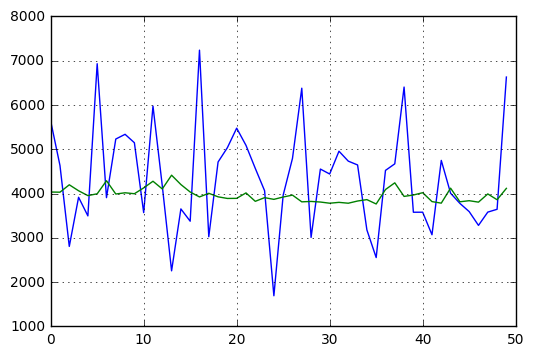

In [152]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a) #Blue
plt.plot(test_a) #Green
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.plot(train_c)
plt.plot(test_c)
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:])
plt.plot(x_range, test_a[zoom_point:])
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:])
plt.plot(test_c[zoom_point:])
plt.grid(True)
plt.show()

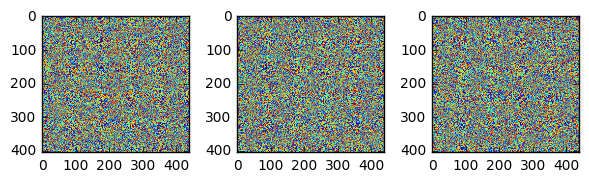

In [69]:
# Re-draw images example
from IPython import display
import time

for i in range(10):
    plt.figure(1)
    plt.subplot(131)
    img1 = plt.imshow(np.random.rand(406,439))
    plt.subplot(132)
    img2 = plt.imshow(np.random.rand(406,439))
    plt.subplot(133)
    img3 = plt.imshow(np.random.rand(406,439))
    plt.tight_layout()
    display.clear_output(wait=True)
    plt.show()
    time.sleep(1.0)

In [ ]:
IMAGE_WIDTH = 406
IMAGE_HEIGHT = 439
IMAGE_DEPTH = 3
LABEL_DEPTH = 1
num_examples_per_epoch = 10000

def read_batch(batch_size, images_queue, labels_queue):
    record_bytes = IMAGE_WIDTH * IMAGE_HEIGHT * IMAGE_DEPTH
    record_bytes_label = IMAGE_WIDTH * IMAGE_HEIGHT * LABEL_DEPTH
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    reader_label = tf.FixedLengthRecordReader(record_bytes=record_bytes_label)
    key, value = reader.read(images_queue)
    key_label, value_label = reader_label.read(labels_queue)
    record_bytes = tf.decode_raw(value, tf.uint8)
    record_bytes_label = tf.decode_raw(value_label, tf.uint8)
    depth_major = tf.reshape(record_bytes,[IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    depth_major_label = tf.reshape(record_bytes_label,[LABEL_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    uint8image = tf.transpose(depth_major, [2, 1, 0])
    uint8label = tf.transpose(depth_major_label, [2, 1, 0])
    reshaped_image = tf.cast(uint8image, tf.float32)
    reshaped_label = tf.cast(uint8label, tf.float32)
    min_fraction_of_examples_in_queue = 0.4
    min_queue_examples = int(num_examples_per_epoch * min_fraction_of_examples_in_queue)
    images, labels = tf.train.batch([reshaped_image, reshaped_label], batch_size=batch_size, capacity=min_queue_examples + 3 * batch_size)
    return images, labels, reshaped_image

In [ ]:
labels_names = [join(basePathLabel, f) for f in fnames]
labels_queue = tf.train.string_input_producer(labels_names)
images_names = [join(basePath, f.split('.')[0] + ".tif") for f in fnames]
images_queue = tf.train.string_input_producer(images_names)

In [ ]:
basePathLabel = "hdfs://10.0.104.163:8020/Projects/SpaceNet/Resources/spacenet-dataset/AOI_1_Rio/processedData/labels_3band/"
basePath = "hdfs://10.0.104.163:8020/Projects/SpaceNet/Resources/spacenet-dataset/AOI_1_Rio/processedData/3band/"
node_endpoint = "http://10.0.104.163:50070/"
client = InsecureClient(node_endpoint)
fnames = client.list("/Projects/SpaceNet/Resources/spacenet-dataset/AOI_1_Rio/processedData/labels_3band/")

In [ ]:
with tf.Session() as sess:
    images, labels, foo = read_batch(5,images_queue,labels_queue)
    print images[0]
    print labels
    sess.run(tf.initialize_all_variables())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    try:
        print "Run..."
        for i in range(20):
            print "i= ",i
            sess.run(images)[0]
    
    except tf.errors.OutOfRangeError:
        print("Done training -- epoch limit reached")
        
    finally:
        coord.request_stop()
    coord.join(threads)
    sess.close()